In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Add, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import ast
from imblearn.over_sampling import RandomOverSampler

2025-04-15 20:19:37.556672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744730377.574874   76667 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744730377.580578   76667 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744730377.594641   76667 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744730377.594672   76667 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744730377.594675   76667 computation_placer.cc:177] computation placer alr

In [2]:
# Ensure TensorFlow uses GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is enabled")
else:
    print("GPU not found. Using CPU.")

GPU is enabled


In [3]:
# Paths
train_images_path = "ODIR-5K/augmented_images"
csv_path = os.path.join('augmented.csv')

# Load labels
df = pd.read_csv(csv_path)
labels_df = df.sample(frac=1, random_state=42)
labels_df['labels'] = labels_df['labels'].apply(lambda x: ast.literal_eval(x)[0])

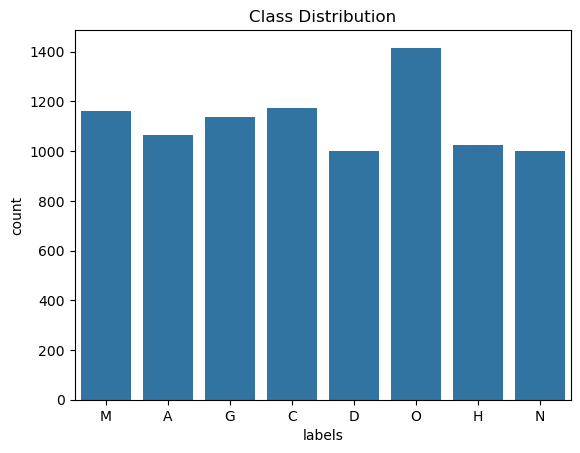

In [4]:
# Visualize class distribution
sns.countplot(x=labels_df['labels'])
plt.title("Class Distribution")
plt.show()

In [5]:
# Load images
images = []
labels = []

def load_images_from_folder(folder_path, labels_df):
    for _, row in labels_df.iterrows():
        file_name = row['filename']
        label = row['labels']
        image_path = os.path.join(folder_path, file_name)
        
        if os.path.exists(image_path) and file_name.endswith(('.jpg', '.jpeg', '.png')):
            image = Image.open(image_path)
            image = image.resize((224, 224))
            image_array = np.array(image)
            if image_array.shape[-1] != 3:
                image_array = np.stack([image_array] * 3, axis=-1) if len(image_array.shape) == 2 else image_array[:, :, :3]
            images.append(image_array)
            labels.append(label)

load_images_from_folder(train_images_path, labels_df)

# Convert to arrays
images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with labels")

Loaded 8972 images with labels


In [6]:
# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Oversampling to handle class imbalance
ros = RandomOverSampler(random_state=42)
images_flat = images.reshape(len(images), -1)  # Flatten images for oversampling
images_resampled, labels_resampled = ros.fit_resample(images_flat, labels_encoded)
images_resampled = images_resampled.reshape(-1, 224, 224, 3)  # Reshape back to original dimensions

In [7]:
# Split dataset
X_train_full, X_test, y_train_full, y_test = train_test_split(images_resampled, labels_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Compute class weights (still useful even after oversampling)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

print(f"Training images: {len(X_train)}")
print(f"Validation images: {len(X_val)}")
print(f"Test images: {len(X_test)}")

Training images: 7249
Validation images: 1813
Test images: 2266


In [ ]:
# Build a deeper CNN with residual connections
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Adjust shortcut if the input and output dimensions don't match
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

In [9]:
# CNN architecture
inputs = Input(shape=(224, 224, 3))

# Initial conv layer
x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Residual blocks
x = residual_block(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, 256)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, 512)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(encoder.classes_), activation='softmax')(x)

# Build model
model = Model(inputs, outputs)

# Compile with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

I0000 00:00:1744731177.058352   76667 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2269 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 31,109,704 (118.67 MB)

 Trainable params: 31,103,880 (118.65 MB)

 Non-trainable params: 5,824 (22.75 KB)

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,  # Increased epochs for better convergence
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)

Epoch 1/100


I0000 00:00:1744731191.524468   89925 service.cc:152] XLA service 0x729ce8003660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744731191.524498   89925 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-04-15 20:33:11.781133: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744731192.924897   89925 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-15 20:33:18.912510: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smal

  1/227 ━━━━━━━━━━━━━━━━━━━━ 2:04:00 33s/step - accuracy: 0.2188 - loss: 4.4304

I0000 00:00:1744731216.034034   89925 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.1798 - loss: 5.7992

2025-04-15 20:34:49.555440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_383_0', 468 bytes spill stores, 1028 bytes spill loads

2025-04-15 20:34:49.760028: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_390', 4 bytes spill stores, 4 bytes spill loads

2025-04-15 20:34:49.949713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_383', 608 bytes spill stores, 608 bytes spill loads

2025-04-15 20:34:49.996331: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_383', 488 bytes spill stores, 488 bytes spill loads

2025-04-15 20:34:50.129287: I externa

227/227 ━━━━━━━━━━━━━━━━━━━━ 117s 373ms/step - accuracy: 0.1799 - loss: 5.7871 - val_accuracy: 0.1384 - val_loss: 2.1753 - learning_rate: 5.0000e-04
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 233ms/step - accuracy: 0.2716 - loss: 1.8863 - val_accuracy: 0.2151 - val_loss: 2.0567 - learning_rate: 5.0000e-04
Epoch 3/100


2025-04-15 20:35:53.440285: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - accuracy: 0.3159 - loss: 1.7872 - val_accuracy: 0.2874 - val_loss: 1.8802 - learning_rate: 5.0000e-04
Epoch 4/100


2025-04-15 20:36:46.701695: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 239ms/step - accuracy: 0.3544 - loss: 1.6688 - val_accuracy: 0.4021 - val_loss: 1.5447 - learning_rate: 5.0000e-04
Epoch 5/100


2025-04-15 20:37:41.275899: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - accuracy: 0.3794 - loss: 1.5970 - val_accuracy: 0.4247 - val_loss: 1.4752 - learning_rate: 5.0000e-04
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 235ms/step - accuracy: 0.4013 - loss: 1.5525 - val_accuracy: 0.4076 - val_loss: 1.5056 - learning_rate: 5.0000e-04
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 235ms/step - accuracy: 0.4226 - loss: 1.4797 - val_accuracy: 0.4589 - val_loss: 1.4419 - learning_rate: 5.0000e-04
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.4225 - loss: 1.4555 - val_accuracy: 0.4175 - val_loss: 1.5097 - learning_rate: 5.0000e-04
Epoch 9/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - accuracy: 0.4318 - loss: 1.4554 - val_accuracy: 0.4744 - val_loss: 1.3809 - learning_rate: 5.0000e-04
Epoch 10/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - accuracy: 0.4386 - loss: 1.4239 - val_accuracy: 0.4639 - val_loss: 1.4386 - learning_rate: 5.0000e-04
Epoch 11/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 235ms

In [11]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7670 - loss: 0.5931

2025-04-15 21:57:55.790970: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_383', 212 bytes spill stores, 244 bytes spill loads

2025-04-15 21:57:55.909274: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_383', 4 bytes spill stores, 4 bytes spill loads

2025-04-15 21:57:56.019227: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_383_0', 592 bytes spill stores, 1236 bytes spill loads

2025-04-15 21:57:56.094357: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_383', 492 bytes spill stores, 492 bytes spill loads

2025-04-15 21:57:56.202008: I externa

71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.7669 - loss: 0.5929
Test Accuracy: 0.7630
Test Loss: 0.5834


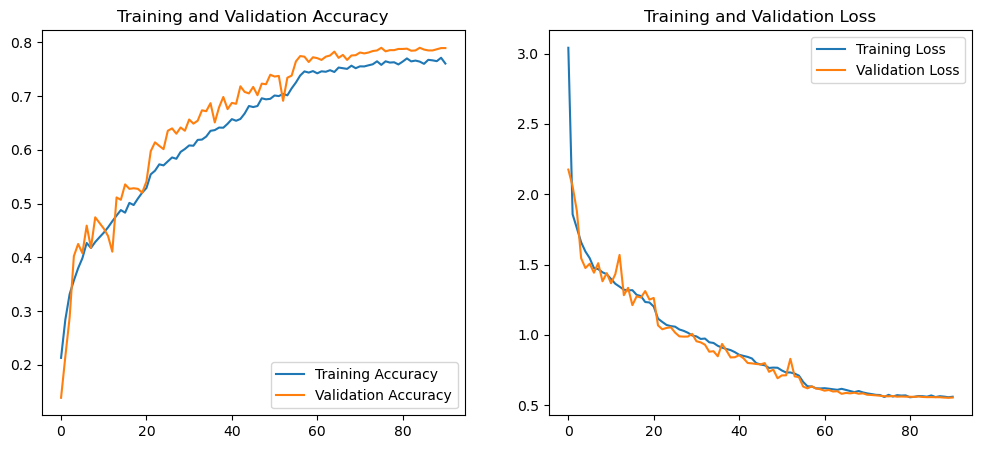

In [12]:
# Plot training and validation metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
from sklearn.metrics import classification_report

generator = test_generator

class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

y_true = []
for i in range(len(generator)):
    _, batch_labels = generator[i]  
    y_true.extend(batch_labels)  
y_true = np.array(y_true)

y_pred_probs = model.predict(generator)
y_pred = np.argmax(y_pred_probs, axis=1)  

print(f"Number of true labels: {len(y_true)}")
print(f"Number of predictions: {len(y_pred)}")

print("Classification Report for Test Generator:")
print(classification_report(y_true, y_pred, target_names=class_names))

71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
Number of true labels: 2266
Number of predictions: 2266
Classification Report for Test Generator:
              precision    recall  f1-score   support

           N       0.81      0.92      0.86       273
           D       0.96      0.99      0.98       296
           G       0.47      0.46      0.47       287
           C       0.89      0.95      0.92       255
           A       0.86      0.96      0.91       269
           H       0.99      1.00      0.99       288
           M       0.49      0.52      0.50       301
           O       0.59      0.36      0.45       297

    accuracy                           0.76      2266
   macro avg       0.76      0.77      0.76      2266
weighted avg       0.75      0.76      0.75      2266

